# ME599 - AI in Clean Energy Watt's Next
Team Members: Ricardo Lee, Evan Muschler, Vinh Nguyen, Noah Tanner

## 1. Installation of Requisite Libraries
Installing the full AeroSandbox package, which contains NeuralFoil and methods for generating parameters from airfoil coordinates.

In [ ]:
!pip install aerosandbox[full]
!pip install pyDOE


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
  Using cached pyDOE-0.3.8-py3-none-any.whl

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## 2. Import Libraries

In [ ]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import random
from scipy.stats import qmc
from scipy.spatial import distance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats import norm
from pyDOE import lhs
import os
from scipy.stats.qmc import Sobol
from itertools import product
import seaborn as sns

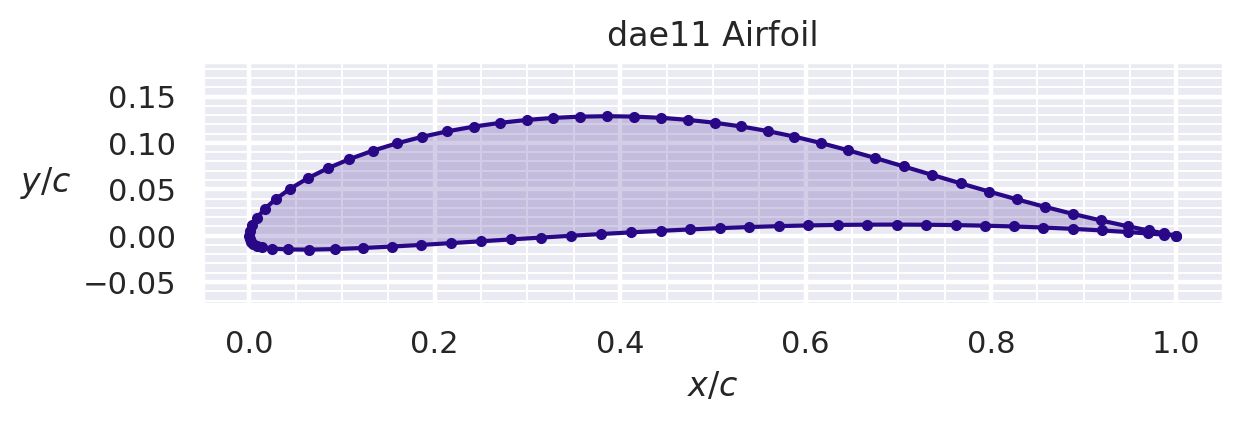

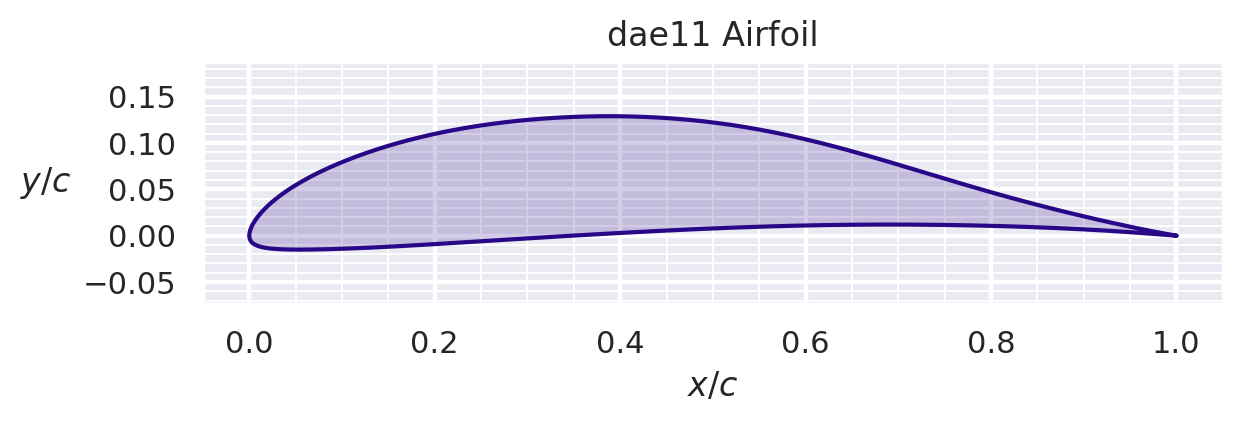

{'lower_weights': array([-0.16310508, -0.14398528,  0.08896135, -0.0706084 ,  0.09741634,
        0.01466031,  0.07888292,  0.08075122]), 'upper_weights': array([0.17036014, 0.15272658, 0.51688551, 0.09212467, 0.66904449,
       0.14345864, 0.28990386, 0.16207357]), 'leading_edge_weight': 0.5035068867316296, 'TE_thickness': 0.00011059192135114138}


In [ ]:
# Testing the packaged airfoil generation code. First makes a regular airfoil from airfoil database.
coordinate_airfoil = asb.Airfoil("dae11")
coordinate_airfoil
fig, ax = plt.subplots(figsize=(6, 2))
coordinate_airfoil.draw()
# Converts airfoil to kulfan parameterized airfoil. It looks the same, but the dots aren't plotted so the figure looks smoother. 
kulfan_airfoil = coordinate_airfoil.to_kulfan_airfoil()
kulfan_airfoil
fig, ax = plt.subplots(figsize=(6, 2))
kulfan_airfoil.draw()
# prints parameters so we can see how data is formatted
print(kulfan_airfoil.kulfan_parameters)

{'lower_weights': [-1, -0.5, 0, 0, -1, 0.5, -1, -0.75], 'upper_weights': array([1., 1., 1., 1., 1., 1., 1., 1.]), 'leading_edge_weight': 0.9, 'TE_thickness': 0.005}


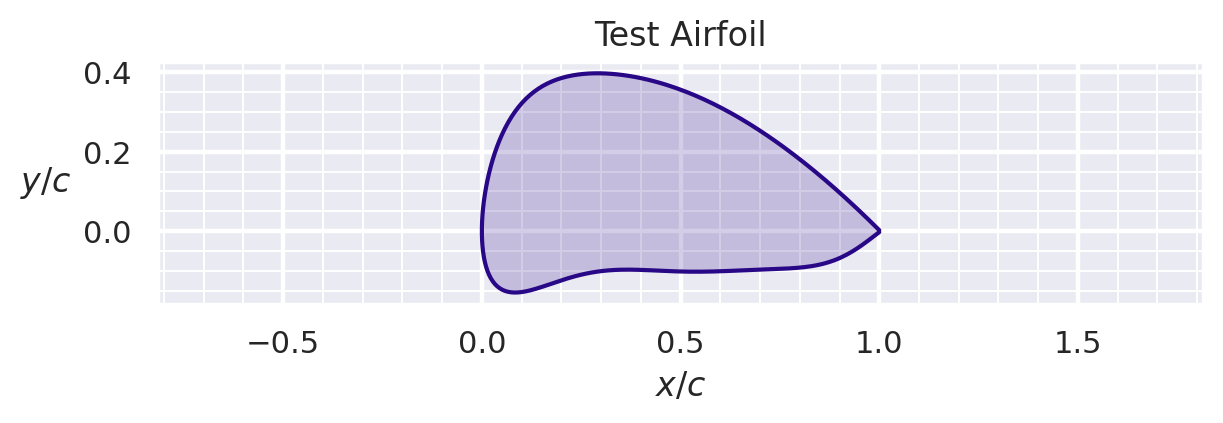

In [ ]:
# test to just see how we can play around with airfoil shapes based on kulfan parameters
test = asb.KulfanAirfoil(
    name="Test",
    lower_weights=[-1, -.5, 0, 0, -1, .5, -1, -.75],
    upper_weights=1.0 * np.ones(8),
    leading_edge_weight=.9,
    TE_thickness=.005,
)
print(test.kulfan_parameters)
fig, ax = plt.subplots(figsize=(6, 2))
test.draw()

## 3. Define Neural Foil Helper Functions
Here, we define helper functions that help us put the Kulfan Parameters into a Bayesian Optimization-friendly state. The Kulfan parameters are by default in a dictionary, but we want them in a single list format for easy data manipulation. 

Also makes helper functions that can make the next foils to try based on the new parameters chosen by Bayesian Optimization.

In [ ]:
from neuralfoil.main import (
    get_aero_from_kulfan_parameters,
    get_aero_from_airfoil,
    get_aero_from_coordinates,
    get_aero_from_dat_file,
    bl_x_points,
)


# This converts the dictionary of Kulfan parameters into a single list. 
def kulfan_to_bo(kf_params):
    list_lower = kf_params["lower_weights"]
    list_upper = kf_params["upper_weights"]
    leading_edge = kf_params["leading_edge_weight"]
    trailing_edge = kf_params["TE_thickness"]
    result = [leading_edge, trailing_edge, *list_upper, *list_lower]
    return result

# This converts the list of Bayesian Optimization parameters back into a Kulfan parameter dictionary for the AeroSanbox library
def bo_to_kulfan(bo):
    result = {"leading_edge_weight": bo[0],
              "TE_thickness": bo[1],
              "upper_weights": bo[2:9],
              "lower_weights": bo[10:17]}
    return result

# Helper function to generate airfoils from given Kulfan parameters. Mostly there to help automate the code during BO process
def make_foil_kf(kf, name):
    foil = asb.KulfanAirfoil(
    name=name,
    lower_weights=kf["lower_weights"],
    upper_weights=kf["upper_weights"],
    leading_edge_weight=kf["leading_edge_weight"],
    TE_thickness=kf["TE_thickness"],
)
    return foil

# makes Kulfan airfoils from just (X,Y) coordinates from the BO optimization or .dat file.
def make_foil_coords(coords, name):
    foil = asb.Airfoil(name = name, coords = coords)
    kf_foil = foil.to_kulfan_airfoil()
    return kf_foil

# generate aero performance variable containing CL and CD over variable angle of attack and reynolds numbers from kulfan parameterized foil
def get_CL_CD_perf(kf_foil):
    # define angles of attack range over which to collect values, these are hardcoded for now
    alpha_start = 1
    alpha_end = 20
    alpha = np.linspace(alpha_start,alpha_end,200)

    # define reynolds number range over which to collect values, these are hardcoded for now
    Re_start = 1e6
    Re_end = 10e6
    Re_list = np.linspace(Re_start, Re_end, 10) 

    # temporary storage lists
    Re_all = []
    alpha_all = []
    CL_all = []
    CD_all = []
    
    # loop over Reynolds numbers
    for Re in Re_list:
        aero_ = get_aero_from_kulfan_parameters(
            kulfan_parameters = kf_foil,
            alpha=alpha,  # NeuralFoil expects degrees
            Re=Re,
            model_size="xxlarge"
        )
    
        Re_all.extend([Re] * len(alpha))
        alpha_all.extend(alpha)
        CL_all.extend(aero_["CL"])
        CD_all.extend(aero_["CD"])
    
    # final neuralfoil aero_performance dictionary as NumPy arrays, with alpha in radians for the BEM code
    aero_performance = {
        "Re": np.array(Re_all, dtype=np.float64),
        "alpha": np.array(np.radians(alpha_all), dtype=np.float64),
        "CL": np.array(CL_all, dtype=np.float64),
        "CD": np.array(CD_all, dtype=np.float64)
    }

    return aero_performance



## 4. Define BEM Functions to Calculate Cp
Define the BEM functions that are used to calculate Cp from AeroSandbox - NeuralFoil's calculations of drag (Cd) and lift (Cl) at different angles of attack.

In [ ]:
from BEM_2 import BEM

def run_BEM(U_design, R, eta_0, lambda_design, r_hub, B, Re_design, aero_performance):
    Re_blade = 3e6 #this is just an initial value to ensure the while loop starts, until it is updated by the BEM code
    
    #loop over BEM code until predicted Re matches output
    while abs(Re_design - Re_blade)/Re_blade > 0.02: #if there is less than a 2% on predicted vs calculated Re
        Re_design = Re_blade #update prediction to calculated value
        CP, P_e, Re_blade = BEM(U_design=U_design, R = R, eta_0=eta_0, lambda_design = lambda_design, r_hub=r_hub, B = B, Re_design = Re_design, aero_performance=aero_performance)

    return CP, P_e

## 5. Define a Bayesian Optimization Model
Defines a Bayesian Optimization Model to optimize Cp given the 18 Kulfan parameters

### 5.1 Define conditions for optimization
What are the conditions that we are trying to optimize our airfoil for? Here, we set wind velocity, Reynolds number ($Re$), Mach number ($M_{inf}$), the hub radius of the wind turbine ($r_{hub}$), the number of blades ($n$), the total turbine radius ($r_t$), and a range for the angle of attack ($\alpha$).

In [ ]:
# These are random right now

re = 106
m_inf = 0.2
r_hub = 50 #m
n = 3 
r_t = 100 #m
alpha = [5, 15]

# Define Input turbine properties
U_design = 8  # Design wind speed [m/s]
R = 25  # Turbine radius [m]
eta_0 = 0.90  # Balance of system efficiency
lambda_design = 8  # Design tip speed ratio
B = 3  # Number of blades
r_hub = 2  # Hub radius [m]
Re_design = 1.5e6 # Starting guess on Reynolds number (1.5e6 is decent)



### 5.2 Define Objective Function

### 5.3 Bayesian Optimization Setup

NOTE: This is Austin's code from class one time. Just a starting point for setup.

In [ ]:
# Optimization Parameters
hyperparameter = 0.01
threshold = 0.025
scaling_factor = 50

# Gaussian Process Regression model
kernel = C(constant_value=1, constant_value_bounds=(1e-3, 1e3)) * RBF(length_scale=1, length_scale_bounds=(1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=False)

# Expected Improvement maximizes implicetly
def expected_improvement(X, X_sample, y_sample, model):
    mu, sigma = model.predict(X, return_std=True)

    optiminal_sample = np.min(y_sample)

    with np.errstate(divide="ignore"):

        imp = mu - optiminal_sample - hyperparameter
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei.flatten()

# Function to propose the next sample point using Expected Improvement
def propose_location(acquisition, X_sample, y_sample, bounds, n_restarts=25):
    dim = X_sample.shape[1]

    def min_obj(x):
        return -acquisition(x.reshape(-1, dim), X_sample, y_sample, gp)

    # Starting points for optimization
    x0_list = np.random.uniform(0, 1, size=(n_restarts, dim))
    best_x, best_val = None, float("inf")
    for x0 in x0_list:
        res = minimize(min_obj, x0, bounds=bounds, method="L-BFGS-B")
        if res.fun < best_val:
            best_val = res.fun
            best_x = res.x
    return best_x

### 5.4 

## 6. Data Visualization
Function to visualize how the airfoil changes shape as it goes through the Bayesian Optimization process

In [93]:
# will plot the number of foils based on a list of Nx2 arrays
def plot_optimization(list_array, num_foils):
    color_palette = sns.color_palette("crest", num_foils + 1)
    fig, ax = plt.subplots(figsize=(6, 2))
    count_array = len(list_array)
    step_size = int(np.floor(count_array/(num_foils - 1)))
    j = 0
    ax.plot(list_array[0][:,0], list_array[0][:,1], color = color_palette[j])
    # ax.plot(list_array[0][:,0], list_array[0][:,1])
    for i in range(1, count_array - 1, step_size):
        j += 1
        ax.plot(list_array[i][:,0], list_array[i][:,1], color = color_palette[j])
        # ax.plot(list_array[i][:,0], list_array[i][:,1])
    ax.plot(list_array[-1][:,0], list_array[-1][:,1], color = color_palette[j+1])
    # ax.plot(list_array[-1][:,0], list_array[-1][:,1])

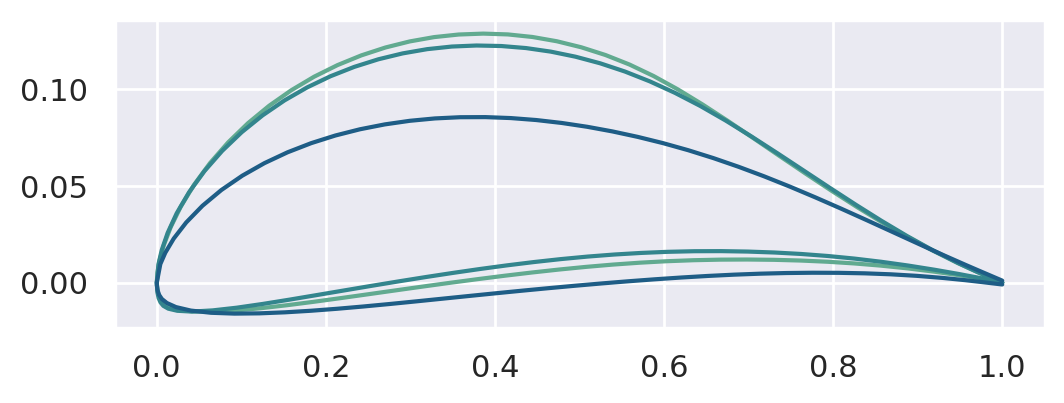

In [94]:
test1 = asb.Airfoil("dae11")
test2 = asb.Airfoil("dae21")
test3 = asb.Airfoil("dae31")
test4 = asb.Airfoil("dae51")
list_array = [test1.coordinates, test2.coordinates, test3.coordinates, test4.coordinates]

plot_optimization(list_array, 2)

In [9]:
bo_test = kulfan_to_bo(test.kulfan_parameters)

print(bo_test)

[0.9, 0.005, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


In [10]:
kf_test = bo_to_kulfan(bo_test)
print(kf_test)

{'leading_edge_weight': 0.9, 'TE_thickness': 0.005, 'upper_weights': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'lower_weights': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]}


In [11]:
test2 = make_foil_kf(kf_test, "Test2")

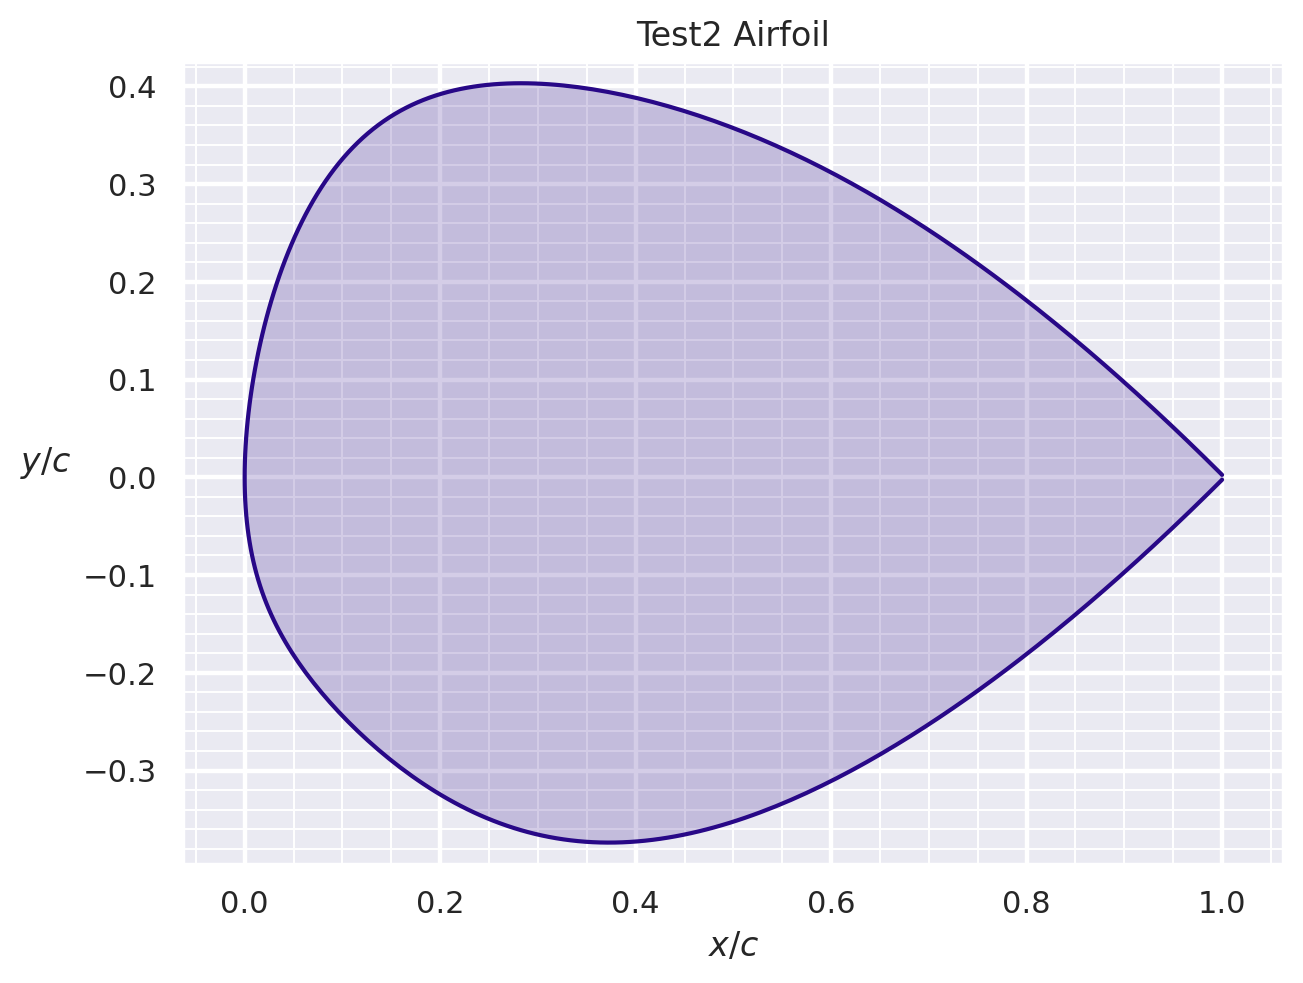

In [12]:
test2.draw()

In [17]:
coords = test2.coordinates
test3 = asb.Airfoil("test3", coords)

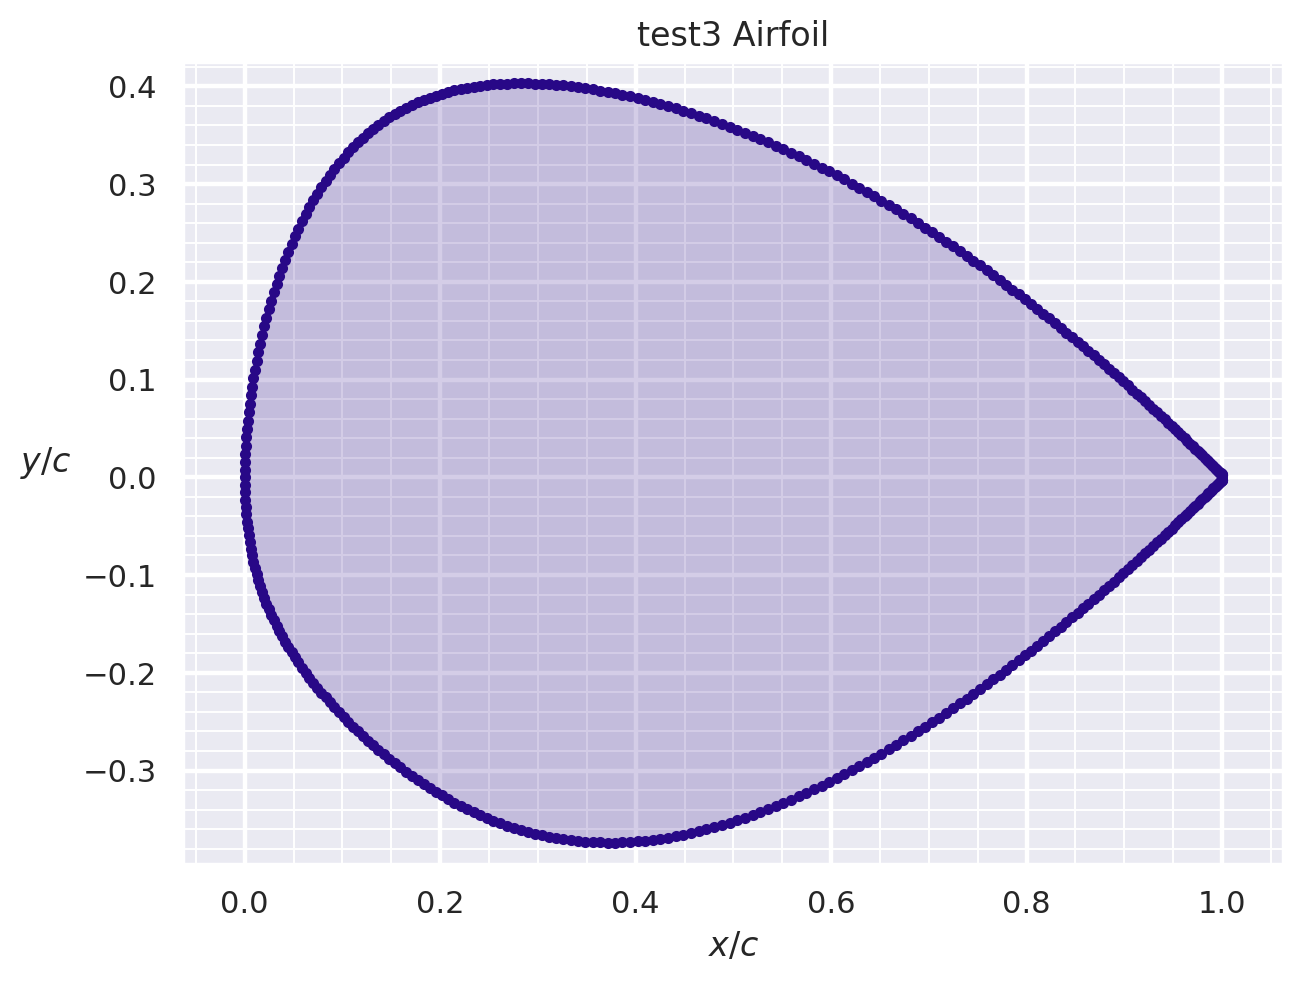

In [18]:
test3.draw()